In [ ]:
import numpy
import random
import numpy
import torch
import torchvision

torch.set_default_dtype(torch.float32)


# Generate [n] ^ [d] random vectors with [d] dimension
# One will be selected randomly and label as 1, the rest as 0
def generate_dateset(d, n):
    values = [-1] * d
    step = 2 / (n - 1)

    x = torch.zeros(n ** d, d)
    for i in range(n ** d):
        for j in range(d):
            x[i] = torch.tensor(values)

        values[0] += step
        for i in range(len(values)):
            if values[i] > 1:
                values[i] = -1
                if i + 1 < len(values):
                    values[i + 1] += step

    x = x.cuda()

    y = torch.zeros(n ** d)
    y[random.randrange(0, torch.numel(y))] = 1.0
    y = y.view(n ** d, 1).cuda()
    return x, y


X, Y = generate_dateset(2, 10)
# print(X)
# print(Y)

In [2]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, layer_size, activation_func=lambda: None):
        super(NeuralNetwork, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.layer_size = layer_size

        self.linear = torch.nn.Sequential(torch.nn.Linear(input_size, layer_size))

        for i in range(hidden_layers):
            self.linear.append(torch.nn.Linear(layer_size, layer_size))
            activation = activation_func()
            if activation is not None:
                self.linear.append(activation)

        self.linear.append(torch.nn.Linear(layer_size, output_size))

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.linear(x)

In [3]:
class TestResult:
    def __init__(self):
        self.epoch_loss_x = []
        self.epoch_loss_y = []
        self.xy_loss_y = []


def run_test_with_network(network, optimizer, loss_func, X, Y, max_epoch):
    n = len(Y)

    result = TestResult()

    for epoch in range(max_epoch):
        network.train()
        losses = []
        optimizer.zero_grad()
        y_pred = network(X)
        loss = loss_func(y_pred, Y).mean()
        loss.backward()
        optimizer.step()

        network.eval()
        result.epoch_loss_x.append(epoch + 1)
        result.epoch_loss_y.append(loss.item())

    with torch.no_grad():
        result.xy_loss_y = network(X).cpu().numpy()

    return result


def new_network(hidden_layers, layer_size, activation_func):
    return NeuralNetwork(dataset_d, 1, hidden_layers, layer_size, activation_func).cuda()


def run_test_with_activation_func(network, optimizer, loss_func, max_epoch):
    return run_test_with_network(network, optimizer, loss_func, X, Y, max_epoch)

In [4]:
import matplotlib.pyplot as plt


def plot_epoch_loss(X, Y):
    plt.plot(X, Y)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


def plot_xy_loss(X, Y, Y_pred):
    X = X.cpu()
    Y = Y.cpu()
    Y_pred = Y_pred

    index = 0
    for i in range(len(Y)):
        if Y[i] == 1:
            index = i
            break

    f, ax = plt.subplots(figsize=(5, 4))

    ax.plot(X[index, 0], X[index, 1], marker="o", markersize=20, markeredgecolor="black", markerfacecolor="none")
    p = ax.scatter(X[:, 0], X[:, 1], c=Y_pred[:, 0], cmap="cool")
    f.colorbar(p)

    ticks = [i / (dataset_n - 1) * 2 - 1 for i in range(dataset_n)]
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.show()

In [155]:
dataset_n = 11
dataset_d = 2

X, Y = generate_dateset(dataset_d, dataset_n)

In [156]:
hidden_layers = 3
layer_size = 16

max_epoch = 50
lr = 0.05
betas = (0.75, 0.95)
eps = 0.01
weight_decay = 0.005

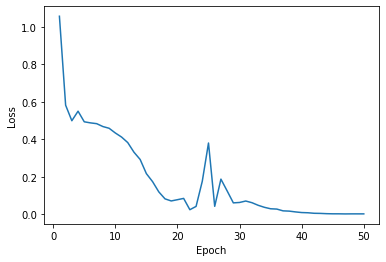

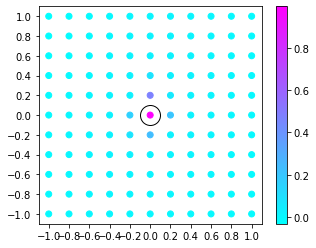

In [157]:
network = new_network(hidden_layers, layer_size, lambda: torch.nn.ReLU())
optimizer = torch.optim.Adam(network.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

def loss(y_pred, y):
    n = len(y)
    l = (y_pred - y) ** 2
    for i in range(n):
        if y[i][0] == 1:
            l[i] *= n
    return l


result = run_test_with_activation_func(network=network, optimizer=optimizer, loss_func=loss, max_epoch=max_epoch)
plot_epoch_loss(result.epoch_loss_x, result.epoch_loss_y)
plot_xy_loss(X, Y, result.xy_loss_y)

In [158]:
import threading

runs = 20

class TestRunThread(threading.Thread):
    def __init__(self, temps, i, activation_func):
        super(TestRunThread, self).__init__()
        self.temps = temps
        self.i = i
        self.activation_func = activation_func

    def run(self):
        network = new_network(hidden_layers, layer_size, self.activation_func)
        optimizer = torch.optim.Adam(network.parameters(), lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        def loss(y_pred, y):
            n = len(y)
            l = (y_pred - y) ** 2
            for i in range(n):
                if y[i][0] == 1:
                    l[i] *= n
            return l

        self.temps[self.i] = run_test_with_activation_func(network=network, optimizer=optimizer, loss_func=loss, max_epoch=max_epoch)

def run_test_a(activation_func):
    result = None
    temps = [None] * runs
    threads = [None] * runs

    for i in range(runs):
        thread = TestRunThread(temps, i, activation_func)
        thread.start()
        threads[i] = thread

    for i in range(runs):
        threads[i].join()
        temp = temps[i]

        if result == None:
            result = temp
        else:
            for i in range(len(temp.epoch_loss_y)):
                result.epoch_loss_y[i] += temp.epoch_loss_y[i]

            for i in range(len(temp.xy_loss_y)):
                result.xy_loss_y[i] += temp.xy_loss_y[i]


    m = 1 / runs
    for i in range(len(temp.epoch_loss_y)):
        result.epoch_loss_y[i] *= m

    for i in range(len(temp.xy_loss_y)):
        result.xy_loss_y[i] *= m

    plot_epoch_loss(result.epoch_loss_x, result.epoch_loss_y)
    plot_xy_loss(X, Y, result.xy_loss_y)

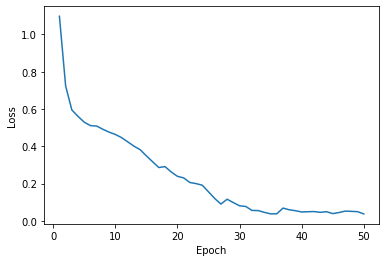

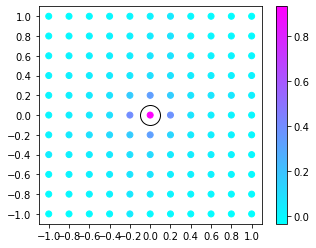

In [159]:
run_test_a(lambda : torch.nn.ReLU())

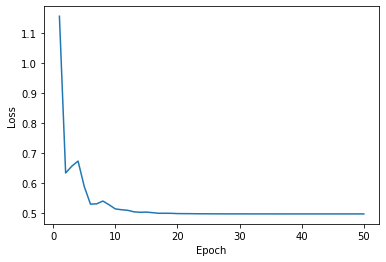

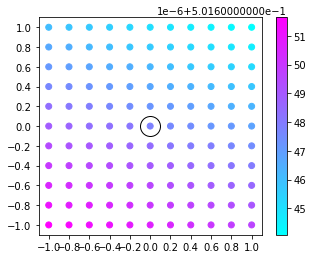

In [160]:
run_test_a(lambda : torch.nn.Sigmoid())